# Find points that belongs to pentagons

In this script, we want to group the data by pentagons. This way we can compute the chirality of each pentagon by looking at the spin values.

In [1]:
import os
import sys
import numpy as np
import scipy
from importlib import reload  
import support as sup
reload(sup)
sys.path.insert(0, '../icenumerics')

import icenumerics as ice

import matplotlib.pyplot as plt
ureg = ice.ureg
from string import Template

import pandas as pd

%load_ext autoreload
%autoreload 2

First, we build our cairo lattice

In [2]:
np.random.seed()

l = 2
a = 19.5458*ureg.um
sp = sup.spins()
ureg = ice.ureg
sp.create_lattice(geometry = "cairo",size =[l,l],lattice_constant=19.5458*ureg.um, border="periodic")

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:283: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY


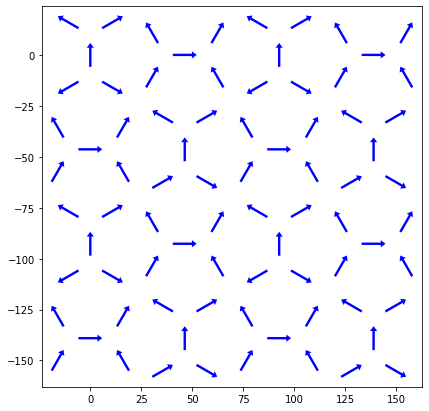

In [3]:
fig, ax1 = plt.subplots(figsize=(10,7))
sp.display(ax1)

And find the centers of the pentagons

In [4]:
def filtrate_horiz_and_vert_spins(sp):
    
    """ Whit this function we filtrate the center values of vertical and horizontal traps. 
    The input parameter is the sp lattice """
    
    cent_vertical = []
    cent_horizontal = []
    cent_all = []
    
    for s in sp:
        
        cent_all.append(s.center.magnitude)

        if (s.direction.magnitude[0] == 0.):

            cent_vertical.append(s.center)

        elif (s.direction.magnitude[1] == 0.):

            cent_horizontal.append(s.center)
            
    return cent_vertical, cent_horizontal, cent_all

In [5]:
vertical, horizontal, cent_all = filtrate_horiz_and_vert_spins(sp)

In [7]:
def pentagon_centers(vertical, horizontal):
    
    """ Whit this function we will define the central points of the pentagons, as input parameters
    it takes the output of the function filtrate_horiz_and_vert() and the output are the centers of the poligon."""
    
    pentagon_centers = []
    
    l = 19.5458*ureg.um*1.37 # Geometrical parameters
    
    for i in vertical:
        
        pentagon_centers.append([i[0].magnitude+(l.magnitude/2*(np.cos(60*np.pi/180)+np.cos(30*np.pi/180))),i[1].magnitude, 0])
        pentagon_centers.append([i[0].magnitude-(l.magnitude/2*(np.cos(60*np.pi/180)+np.cos(30*np.pi/180))),i[1].magnitude, 0])
        
    for i in horizontal:
        
        pentagon_centers.append([i[0].magnitude,i[1].magnitude+(l.magnitude/2*(np.cos(60*np.pi/180)+np.cos(30*np.pi/180))), 0])
        pentagon_centers.append([i[0].magnitude,i[1].magnitude-(l.magnitude/2*(np.cos(60*np.pi/180)+np.cos(30*np.pi/180))), 0])
        
     
    pentagon_cent = np.array(pentagon_centers)
    
    return pentagon_cent
        

In [8]:
center_pentagon_points = pentagon_centers(vertical, horizontal)

In [9]:
lattice_points = np.stack(  cent_all, axis=0 )

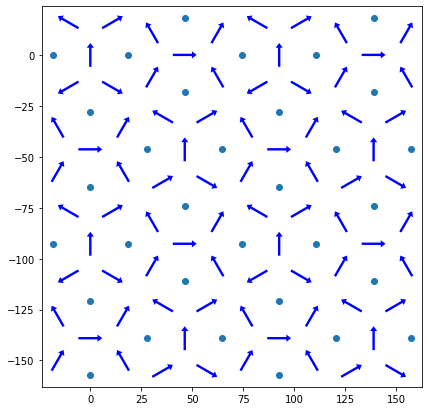

In [10]:
fig, ax1 = plt.subplots(figsize=(10,7))
sp.display(ax1)
plt.plot(center_pentagon_points[:,0],center_pentagon_points[:,1],'o')

To find the 5 nearest neighbours of each center we will build a kdtree and find the nn

In [11]:
KDTree = scipy.spatial.KDTree(lattice_points)

In [12]:
dist, nn_index = KDTree.query(center_pentagon_points, k=5)

In [13]:
nn_index

array([[ 6,  7,  1,  3,  0],
       [ 2,  4,  0,  1,  3],
       [32, 33, 17, 19, 15],
       [11, 14, 16, 18, 15],
       [26, 27, 21, 23, 20],
       [ 8,  9, 22, 24, 20],
       [37, 39, 35, 36, 38],
       [31, 34, 36, 38, 35],
       [46, 47, 41, 43, 40],
       [42, 44, 40, 41, 43],
       [72, 73, 57, 59, 55],
       [51, 54, 56, 58, 55],
       [66, 67, 61, 63, 60],
       [48, 49, 62, 64, 60],
       [77, 79, 75, 76, 78],
       [71, 74, 76, 78, 75],
       [ 6,  8,  5,  7,  9],
       [16, 17,  7,  9,  5],
       [ 3,  4, 11, 12, 10],
       [41, 42, 13, 14, 10],
       [26, 28, 25, 27, 29],
       [36, 37, 27, 29, 25],
       [23, 24, 31, 32, 30],
       [61, 62, 33, 34, 30],
       [18, 19, 46, 48, 45],
       [56, 57, 47, 49, 45],
       [43, 44, 51, 52, 50],
       [53, 54, 50, 51, 52],
       [38, 39, 66, 68, 65],
       [76, 77, 67, 69, 65],
       [63, 64, 71, 72, 70],
       [73, 74, 70, 71, 72]])

In [14]:
nn_index[0]

array([6, 7, 1, 3, 0])

In [15]:
nn = []
for i in nn_index[19]:
    nn.append(KDTree.data[i])


In [16]:
nn = np.stack( nn, axis=0 )

(-17.65072488213483,
 17.650724882134835,
 -78.17314244310448,
 -44.83668790394346)

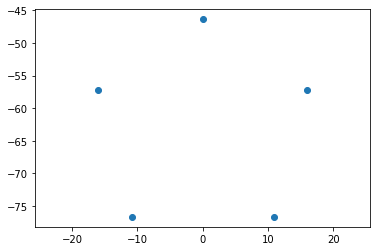

In [17]:
plt.plot(nn[:,0],nn[:,1],'o')
plt.axis('equal')

    It works!!

To get into the position of each label of each side of the pentagon we can write as following:
For the dataset [ 0,  1,  3,  6,  7], the traps involved have the labels 0, 1, 3, 6 and 7. To have the positions we simply do KDTree.data[label]

In [17]:
KDTree.data[1]

array([10.86552456, 16.04611353,  0.        ])

It would be nice to have a collection of traps positions grouped by the index of the pentagon that belong to. After that, we will need to compare this dataframe with the experimental one, and match the indices. Let's do that:

In [18]:
def save_pentagons_and_coord(nn_index):
    
    """ This function takes the indices of the spins forming each pentagon and have as an output a dataframe
    with the index of the pentagon (form 0 to N) and the coordinates of each spin that belongs to the pentagon."""

    index = []
    x = []
    y = []
    z = []

    i = 0

    for pentagon in nn_index:


        for spin_index in pentagon:

            index.append(i)
            x.append(KDTree.data[spin_index][0])
            y.append(KDTree.data[spin_index][1])
            z.append(KDTree.data[spin_index][2])

        i = i+1


    d = {'x': x, 'y': y, 'z': z}

    df = pd.DataFrame(data=d, index = index)
    df.index.name = 'pentagon index'

    return df

In [19]:
df = save_pentagons_and_coord(nn_index)

In [20]:
df

,x,y,z
pentagon index,,,
0,0.000000,0.000000,0.0
0,10.865525,16.046114,0.0
0,10.865525,-16.046114,0.0
0,30.305868,10.865525,0.0
0,30.305868,-10.865525,0.0
...,...,...,...
31,92.703963,-139.055944,0.0
31,76.657849,-149.921468,0.0
31,108.750076,-149.921468,0.0


To compute the chirality of a pentagon we need to compare it with something else. Because of that, we will define which kind of pentagon we have "up", "down", "right" and "left". After that, we will define the clockwise direction of each spin of the pentagon. 

The idea is having a dataframe with the clockwise chirality of all the pentagons, to compare it with the experimental data and determine if the experimental pentagon is clockwise, counterclockwise or achiral. 

In [32]:
def pentagon_type(df):
    
    """ In this function, we classify the pentagons in 'up', 'down', 'right' and 'left' 
    input: dataframe
    output: dataframe 
    """
    
    df['pentagon type'] = np.NaN
    
    for i,typ in df.groupby('pentagon index'):
        
        x_max = typ.x.max()
        y_max = typ.y.max()
        
        x_min = typ.x.min()
        y_min = typ.y.min()
        
        freq_x = typ.x.value_counts()
        freq_x = freq_x.to_frame(name= "freq")
        
        freq_y = typ.y.value_counts()
        freq_y = freq_y.to_frame(name= "freq")
        
        if freq_x.loc[x_max].freq == 2:
            
            df.loc[i,'pentagon type'] = "right"
            
        elif freq_x.loc[x_min].freq == 2:
            
            df.loc[i,'pentagon type'] =  "left"
            
        elif freq_y.loc[y_max].freq == 2:
            
            df.loc[i,'pentagon type'] =  "up"
            
        elif freq_y.loc[y_min].freq == 2:
            
            df.loc[i,'pentagon type'] =  "down"
        
        df.set_index('pentagon type')
            
    return df

In [35]:
df = pentagon_type(df)
df

,x,y,z,pentagon type
pentagon index,,,,
0,0.000000,0.000000,0.0,right
0,10.865525,16.046114,0.0,right
0,10.865525,-16.046114,0.0,right
0,30.305868,10.865525,0.0,right
0,30.305868,-10.865525,0.0,right
...,...,...,...,...
31,92.703963,-139.055944,0.0,right
31,76.657849,-149.921468,0.0,right
31,108.750076,-149.921468,0.0,right


In [99]:
def clockwise_chirality(df):
    
    """ In this function, I will label the spins in each pentagon and I will assign the signs of the spins 
    to have a clockwise chirality
    
    input: dataframe 
    output: dataframe with new column """
    
    df['label'] = np.NaN
    df['sign_x'] = np.NaN
    df['sign_y'] = np.NaN
    
    for i,typ in df.groupby('pentagon index'):
    
        if (typ['pentagon type'] == "up").all() :
            
            typ
            
        elif (typ['pentagon type'] == 'down').all():
            
            pass
            
        elif (typ['pentagon type'] == 'right').all():
            
            pass
            
        elif (typ['pentagon type'] == 'left').all():
            
            pass
    
    
    return df

In [101]:
clockwise_chirality(df)

18
                        x          y    z pentagon type  label  sign_x  sign_y
pentagon index                                                                
18               0.000000 -46.351981  0.0            up    NaN     NaN     NaN
18              16.046114 -35.486457  0.0            up    NaN     NaN     NaN
18             -16.046114 -35.486457  0.0            up    NaN     NaN     NaN
18              10.865525 -16.046114  0.0            up    NaN     NaN     NaN
18             -10.865525 -16.046114  0.0            up    NaN     NaN     NaN
22
                         x          y    z pentagon type  label  sign_x  \
pentagon index                                                            
22               92.703963 -46.351981  0.0            up    NaN     NaN   
22              108.750076 -35.486457  0.0            up    NaN     NaN   
22               76.657849 -35.486457  0.0            up    NaN     NaN   
22              103.569487 -16.046114  0.0            up    NaN   

,x,y,z,pentagon type,label,sign_x,sign_y
pentagon index,,,,,,,
0,0.000000,0.000000,0.0,right,NaN,NaN,NaN
0,10.865525,16.046114,0.0,right,NaN,NaN,NaN
0,10.865525,-16.046114,0.0,right,NaN,NaN,NaN
0,30.305868,10.865525,0.0,right,NaN,NaN,NaN
0,30.305868,-10.865525,0.0,right,NaN,NaN,NaN
...,...,...,...,...,...,...,...
31,92.703963,-139.055944,0.0,right,NaN,NaN,NaN
31,76.657849,-149.921468,0.0,right,NaN,NaN,NaN
31,108.750076,-149.921468,0.0,right,NaN,NaN,NaN


We save the data to compare it with the experimental one. 

In [ ]:
#df.to_csv('Pentagon_coordinates_Script-9.1.dat' , sep='\t')

# Issues

    
    - NN at the boundaries generate wrong pentagons 
        
<font color='red'> NOT SOLVED! </font>